In [1]:
# sky_hotspots_kmean.ipynb
# Authors: Stephan Meighen-Berger
# Performs a check if the hotspots change with increasing number of seeds
# using a kmean approach

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pickle
import csv
from tqdm import tqdm
from sklearn.cluster import KMeans
import imageio
import os

In [3]:
# picture path
PICS = '../pics/'

In [4]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [5]:
# Plotting standards
std_size = 6.
fontsize = 20.
lw=1.
h_length=1.
mark_s = 10
# params
mag_fit = 1.
colors = ['#fef0d9', '#fdcc8a', '#fc8d59', '#e34a33', '#b30000']
alphas = [0.2, 0.4, 0.6, 0.8, 1.]
# labels_mass = ['1\;TeV', '100\;TeV', '10\;PeV', '30\;TeV']
linest = ['-', '--', '-.', ':']

In [6]:
# Constants
minutes = 60.
days = 60. * 24

In [7]:
def ice_parser(filename):
    store = []
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row_num, row in enumerate(reader):
            if row_num == 0:
                continue
            store.append(row[0].split())
    store = np.array(store, dtype=float)
    return store

In [8]:
# MJD, log10(E/GeV), AngErr[deg], RA[deg], Dec[deg], Azimuth[deg], Zenith[deg]
data_sets = [
    '../data/icecube_10year_ps/events/IC40_exp.csv',
    '../data/icecube_10year_ps/events/IC59_exp.csv',
    '../data/icecube_10year_ps/events/IC79_exp.csv',
    '../data/icecube_10year_ps/events/IC86_I_exp.csv',
    '../data/icecube_10year_ps/events/IC86_II_exp.csv',
    '../data/icecube_10year_ps/events/IC86_III_exp.csv',
    '../data/icecube_10year_ps/events/IC86_IV_exp.csv',
    '../data/icecube_10year_ps/events/IC86_V_exp.csv',
    '../data/icecube_10year_ps/events/IC86_VI_exp.csv',
    '../data/icecube_10year_ps/events/IC86_VII_exp.csv',
]
event_dic = {
    0: ice_parser(data_sets[0]),
    1: ice_parser(data_sets[1]),
    2: ice_parser(data_sets[2]),
    3: ice_parser(data_sets[3]),
    4: ice_parser(data_sets[4]),
    5: ice_parser(data_sets[5]),
    6: ice_parser(data_sets[6]),
    7: ice_parser(data_sets[7]),
    8: ice_parser(data_sets[8]),
    9: ice_parser(data_sets[9]),
}

C:\Users\steph\Anaconda3\envs\dmpoint\lib\site-packages\numpy\ma\core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


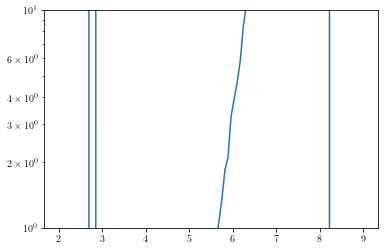

In [9]:
# Loading weights
weights = pickle.load(open("..\\data\\weights.pkl", "rb"))
plt.semilogy(np.linspace(2., 9., 100), weights(np.linspace(0., 10., 100)))

In [10]:
def data_filter(event_dic, energy_range, angle_range, years):
    # filters the data in energy and angle
    filtered_dic = {}
    for year in years:
        # where method is faster as basic slicing
        energy_filter_1 = event_dic[year][np.where(event_dic[year][:, 1] < energy_range[1])]
        energy_filter_2 = energy_filter_1[np.where(energy_filter_1[:, 1] > energy_range[0])]
        high_angle = angle_range[1]
        angle_filter_1 = energy_filter_2[np.where(energy_filter_2[:, 4] < high_angle)]
        low_angle = angle_range[0]
        angle_filter_2 = angle_filter_1[np.where(angle_filter_1[:, 4] > low_angle)]
        filtered_dic[year] = angle_filter_2
    return filtered_dic

In [11]:
filtered_data = data_filter(event_dic, [4., 9.], [0., 90.], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [12]:
# Construct weighted events
def weighted_events(event_dic, weight_func, years):
    weighted_data = []
    for year in years:
        weighted_data.append(np.array([
            event_dic[year][:, 3],
            event_dic[year][:, 4],
            weight_func(event_dic[year][:, 1])
        ]))
        weighted_data[-1] = weighted_data[-1].T
    return np.concatenate([weighted_data[year] for year in years])
weighted_data = weighted_events(filtered_data, weights, range(10))

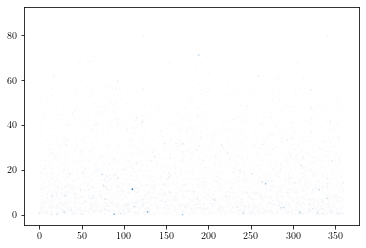

In [13]:
plt.scatter(weighted_data[:, 0], weighted_data[:, 1], s=0.5, alpha=weighted_data[:, 2] / max(weighted_data[:, 2]))

In [14]:
# Modifying data for kmeans
coordinates = weighted_data[:, :2]
event_weights = weighted_data[:, 2]

In [15]:
# Number of events
print(len(event_weights))

6934


In [16]:
# Clustering example
kmeans = KMeans(n_clusters=10, random_state=0)
weighted_fit = kmeans.fit(X=coordinates, sample_weight=event_weights)
predicted_kmeans = kmeans.predict(X=coordinates, sample_weight=event_weights)

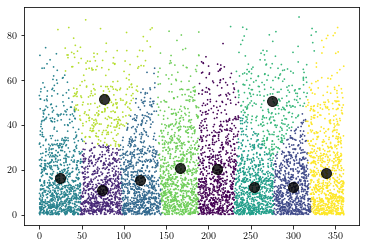

In [17]:
# Plotting kmeans example
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=predicted_kmeans, s=0.5, cmap='viridis')
centers = weighted_fit.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.8)

In [18]:
# Checking if cluster positions change over time
wcss = []
predicted_kmeans_arr = []
cluster_positions = []
seeds = np.arange(500)[10:]
for i in tqdm(seeds):
    kmeans = KMeans(n_clusters=i, init='k-means++',
                    max_iter=300, n_init=10, random_state=0)
    weighted_fit = kmeans.fit(X=coordinates, sample_weight=event_weights)
    predicted_kmeans = kmeans.predict(X=coordinates, sample_weight=event_weights)
    wcss.append(kmeans.inertia_)
    predicted_kmeans_arr.append(predicted_kmeans)
    cluster_positions.append(weighted_fit.cluster_centers_)

100%|██████████| 490/490 [35:42<00:00,  4.37s/it]


In [19]:
filenames = []
for i in tqdm(range(len(seeds))):
    # plot the line chart
    fig = plt.figure(figsize=(10, 8))
    plt.scatter(coordinates[:, 0], coordinates[:, 1],
                c=predicted_kmeans_arr[i], s=1., cmap='viridis')
    plt.scatter(cluster_positions[i][:, 0], cluster_positions[i][:, 1],
                c='black', s=20, alpha=1., marker="+")
    plt.ylim(0., 90.)
    plt.xlim(0., 360.)
    plt.title("Clusters = %d" %seeds[i])
    
    # create file name and append it to a list
    filename = f'..\\pics\\frames\\{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename, dpi=100)
    plt.close()
# build gif
with imageio.get_writer('..\\pics\\cluster_shifts.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

  6%|▌         | 28/490 [00:13<03:36,  2.13it/s]